In [1]:
"""
COMP 559 Homework 3 Non-linear Embedding

"""

'\nCOMP 559 Homework 3 Non-linear Embedding\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
from os import sys
sys.path.append("../../../graph_tools")
sys.path.append("../../../../python_tools/python_tools/")

In [7]:
import networkx_utils as xu
import graph_statistics as gs
import graph_preprocessing as gpre
import networkx as nx
import matplotlib.pyplot as plt

# Helper Functions

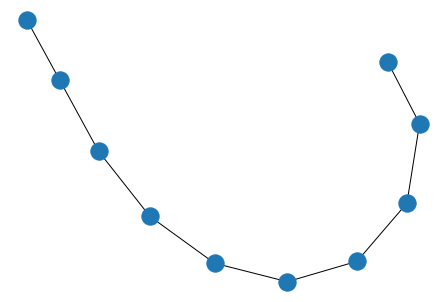

In [17]:
G = nx.path_graph(10)
nx.draw(G, pos=pos)

In [14]:
import numpy as np
def laplacian(G,dense = True):
    L = nx.laplacian_matrix(G)
    if dense:
        L = L.todense()
    return L
    
def laplacian_eig_vals_vecs(G):
    L = laplacian(G)
    eigvals, eigvecs = np.linalg.eigh(L)
    return eigvals, eigvecs

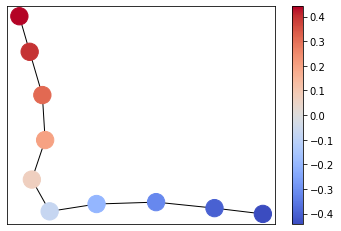

In [24]:
def draw_G_with_color_array(
    G,
    colors,
    pos = None,
    vmin = None,
    vmax = None,
    cmap = plt.cm.coolwarm,
    ):
    colors = np.array(colors).reshape(-1)
    
    if vmin is None:
        vmin = np.min(colors)
    if vmax is None:
        vmax = np.max(colors)
        
    if pos is None:
        pos = nx.spring_layout(G)
        
    nx.draw_networkx(
        G, 
        pos=pos, 
        node_color=colors,
        cmap=cmap, 
        vmin=vmin, 
        vmax=vmax, 
        with_labels=False)
    
    sm = plt.cm.ScalarMappable(
        cmap=cmap,
        norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.show()
    
eigvals,eigvecs = laplacian_eig_vals_vecs(G)
draw_G_with_color_array(
    G,
    eigvecs[:,1]
)

# Importing the MNIST dataset

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import h5py 
from functools import reduce
def hdf5(path,
         data_key = "data", 
         target_key = "target", 
         flatten = True):
    """
        loads data from hdf5: 
        - hdf5 should have 'train' and 'test' groups 
        - each group should have 'data' and 'target' dataset or spcify the key
        - flatten means to flatten images N * (C * H * W) as N * D array
    """
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get(data_key)[:]
        y_tr = train.get(target_key)[:]
        test = hf.get('test')
        X_te = test.get(data_key)[:]
        y_te = test.get(target_key)[:]
        if flatten:
            X_tr = X_tr.reshape(X_tr.shape[0], reduce(lambda a, b: a * b, X_tr.shape[1:]))
            X_te = X_te.reshape(X_te.shape[0], reduce(lambda a, b: a * b, X_te.shape[1:]))
    return X_tr, y_tr, X_te, y_te

In [28]:
X_tr, y_tr, X_te, y_te = hdf5("./usps.h5")
X_tr.shape, X_te.shape

((7291, 256), (2007, 256))

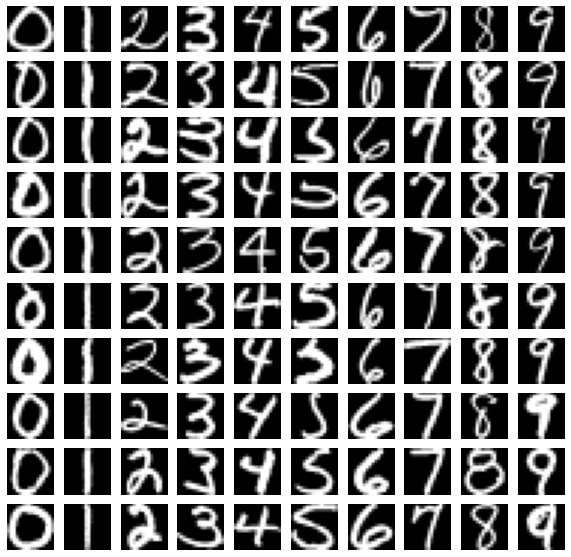

In [29]:
num_samples = 10
num_classes = len(set(y_tr))

classes = set(y_tr)
num_classes = len(classes)
fig, ax = plt.subplots(num_samples, num_classes, sharex = True, sharey = True, figsize=(num_classes, num_samples))

for label in range(num_classes):
    class_idxs = np.where(y_tr == label)
    for i, idx in enumerate(np.random.randint(0, class_idxs[0].shape[0], num_samples)):
        ax[i, label].imshow(X_tr[class_idxs[0][idx]].reshape([16, 16]), 'gray')
        ax[i, label].set_axis_off()

In [31]:
X_tr.shape

(7291, 256)

# Example of building a classifier

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X=X_tr, y=y_tr)

preds = knn_clf.predict(X_te)
accuracy = sum((preds == y_te))/len(y_te)
print("Accuracy of KNN, ", accuracy)

Accuracy of KNN,  0.9446935724962631


# ---- Running Dimensionality Reductions ---

# -- doing the necessary preprocessing --

# -- PCA --

In [34]:
from sklearn import decomposition
n_components = X_tr.shape[1]
pca = decomposition.PCA(n_components = n_components)
pca.fit(X_tr)
X_proj = pca.transform(X_tr)

In [40]:
%matplotlib notebook

<IPython.core.display.Javascript object>


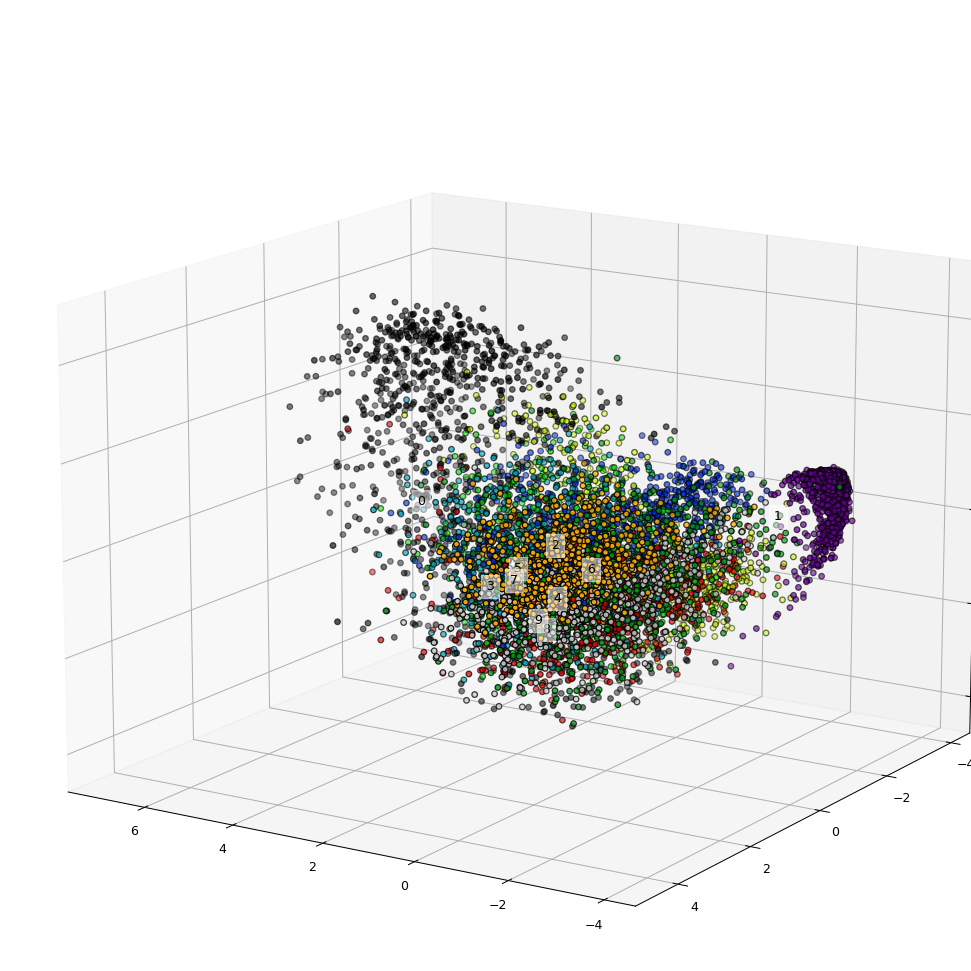

In [43]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3D_projection(
    X,y,
    include_text = True,
    figsize=(4, 3)
    ):

    # Plotting the projection in 3D
    fig = plt.figure(1, figsize)
    plt.clf()

    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

    if include_text:
        for label in np.unique(y):
            ax.text3D(
                X[y == label, 0].mean(),
                X[y == label, 1].mean() + 1.5,
                X[y == label, 2].mean(),
                label,
                horizontalalignment="center",
                bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
            )

        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, 
                   cmap=plt.cm.nipy_spectral, edgecolor="k")
        
        
plot_3D_projection(X_proj,y_tr,figsize=(12,12))